# <center> Предсказание пола клиента </center>

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [22]:
#adding requirements
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

In [23]:
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")

transactions = pd.read_csv("data/transactions.csv", index_col="customer_id")
gender = pd.read_csv("data/gender.csv", index_col="customer_id")

# Data exploration

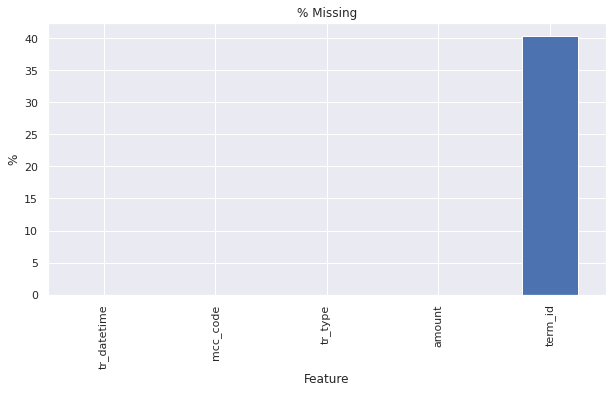

In [32]:
import matplotlib.pyplot as plt

# Plot % missing values
plt.figure(figsize=(10,5))
(transactions.isnull().sum(axis = 0) / transactions.shape[0] * 100).plot.bar()
plt.title('% Missing')
plt.xlabel('Feature')
plt.ylabel('%')
plt.show()

[4651 3749]


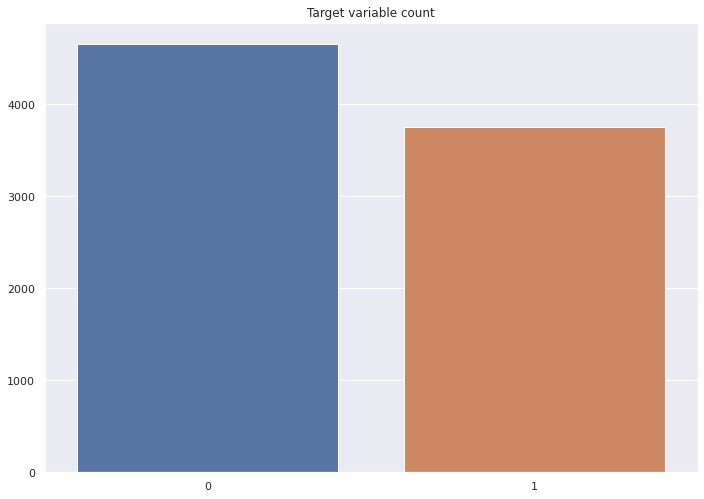

In [33]:
#check the classes distribution
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 

x = gender['gender'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count');
print(x)

# Let’s start 


In [34]:
#adding requirements
def train_feature_engineering(Data, gender):

    Data = pd.merge(Data, gender, left_on='customer_id', right_on='customer_id', how='inner')
    #feature aggregating
    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].sum() > 0, name = 'agg_sign_id', index = Data.index)
    Data['agg_sign_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].sum(), name = 'agg_sum_id', index = Data.index)
    Data['agg_sum_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].count(), name = 'agg_count_id', index = Data.index)
    Data['agg_count_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].mean(), name = 'agg_mean_id', index = Data.index)
    Data['agg_mean_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].max(), name = 'agg_max_id', index = Data.index)
    Data['agg_max_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].min(), name = 'agg_min_id', index = Data.index)
    Data['agg_min_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['mcc_code'].count(), name = 'agg_count_mcc', index = Data.index)
    Data['agg_count_mcc'] = agg_count_id

    keys_1 = dict(Data.groupby(Data['mcc_code'])['amount'].count())
    agg_count_id = Data['mcc_code'].apply(lambda x: keys_1[x])
    Data['agg_count_mcc_unique'] = agg_count_id

    keys_2 = dict(Data.groupby(Data['mcc_code'])['amount'].sum())
    agg_count_id = Data['mcc_code'].apply(lambda x: keys_2[x])
    Data['agg_sum_mcc'] = agg_count_id
    
    keys_3 = dict(Data.groupby(Data['mcc_code'])['amount'].nunique())
    agg_count_id = Data['mcc_code'].apply(lambda x: keys_3[x])
    Data['agg_sum_mcc_unique_type'] = agg_count_id

    mcc_amount_key = dict(Data.set_index(['mcc_code', 'gender']).groupby(level=[0,1])['amount'].mean())
    agg_count_id = Data['mcc_code'].apply(lambda x: max(mcc_amount_key[(x, 1.0)] if (x, 1.0) in mcc_amount_key else 0,
    mcc_amount_key[(x, 0.0)] if (x, 0.0) in mcc_amount_key else 0))
    Data['mcc_amount_key'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['tr_datetime'].nunique(), name = 'days_unique', index = Data.index)
    Data['days_unique'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['tr_datetime'].count(), name = 'days_all', index = Data.index)
    Data['days_all'] = agg_count_id
 
    keys_mcc = dict(Data.groupby(Data['mcc_code']).apply(lambda x: x['gender'] == 1.0).groupby(level=['mcc_code']).mean())
    agg_count_id = Data['mcc_code'].apply(lambda x: keys_mcc[x])
    Data['mcc_gender'] = agg_count_id

    keys_type = dict(Data.groupby(Data['tr_type']).apply(lambda x: x['gender'] == 1.0).groupby(level=['tr_type']).mean())
    agg_count_id = Data['tr_type'].apply(lambda x: keys_type[x])
    Data['tr_type_gender'] = agg_count_id

    return Data, keys_mcc, keys_type, mcc_amount_key, keys_1, keys_2, keys_3 #, my_scaler

def test_feature_engineering(Data, keys_mcc, keys_type, mcc_amount_key, keys_1, keys_2, keys_3):

    #feature aggregating
    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].sum() > 0, name = 'agg_sign_id', index = Data.index)
    Data['agg_sign_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].sum(), name = 'agg_sum_id', index = Data.index)
    Data['agg_sum_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].count(), name = 'agg_count_id', index = Data.index)
    Data['agg_count_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].mean(), name = 'agg_mean_id', index = Data.index)
    Data['agg_mean_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].max(), name = 'agg_max_id', index = Data.index)
    Data['agg_max_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['amount'].min(), name = 'agg_min_id', index = Data.index)
    Data['agg_min_id'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['mcc_code'].count(), name = 'agg_count_mcc', index = Data.index)
    Data['agg_count_mcc'] = agg_count_id

    agg_count_id = Data['mcc_code'].apply(lambda x: keys_1[x])
    Data['agg_count_mcc_unique'] = agg_count_id

    agg_count_id = Data['mcc_code'].apply(lambda x: keys_2[x])
    Data['agg_sum_mcc'] = agg_count_id
    
    agg_count_id = Data['mcc_code'].apply(lambda x: keys_3[x])
    Data['agg_sum_mcc_unique_type'] = agg_count_id

    agg_count_id = Data['mcc_code'].apply(lambda x: max(mcc_amount_key[(x, 1.0)] if (x, 1.0) in mcc_amount_key else 0,
     mcc_amount_key[(x, 0.0)] if (x, 0.0) in mcc_amount_key else 0))
    Data['mcc_amount_key'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['tr_datetime'].nunique(), name = 'days_unique', index = Data.index)
    Data['days_unique'] = agg_count_id

    agg_count_id = pd.Series(Data.groupby(Data.index)['tr_datetime'].count(), name = 'days_all', index = Data.index)
    Data['days_all'] = agg_count_id
 
    agg_count_id = Data['mcc_code'].apply(lambda x: keys_mcc[x])
    Data['mcc_gender'] = agg_count_id

    agg_count_id = Data['tr_type'].apply(lambda x: keys_type[x] if x in keys_type else 0)
    Data['tr_type_gender'] = agg_count_id
    
    return Data


In [36]:
import numpy as np
pd.options.mode.chained_assignment = None

def preprocess_pipeline(drop = True, verbose = False):

    SPLIT_RATIO = 0.99
    
    tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
    tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")

    transactions = pd.read_csv("data/transactions.csv", index_col="customer_id")
    gender = pd.read_csv("data/gender.csv", index_col="customer_id")

    transactions.drop(columns=['term_id'], inplace=True)
    transactions['tr_datetime'] = transactions['tr_datetime'].apply(lambda x: int(x.split(' ')[0]))

    ind = transactions.index.unique()[int(len(transactions.index.unique())*SPLIT_RATIO)]
    train = transactions[transactions.index >= ind]
    test = transactions[transactions.index < ind]

    print('fraction of unique people in test', (len(test.index.unique())/(len(test.index.unique()) + len(train.index.unique())))*100)
    print('fraction of test set', (len(test.index)/(len(test.index) + len(train.index)))*100)

    train, keys_mcc, keys_type, mcc_amount_key, keys_1, keys_2, keys_3 = train_feature_engineering(train, gender)
    test = test_feature_engineering(test, keys_mcc, keys_type, mcc_amount_key, keys_1, keys_2, keys_3)
    test = pd.merge(test, gender, left_on='customer_id', right_on='customer_id', how='inner')
    
    train_nan = train[train['gender'].isna()]
    test_nan = test[test['gender'].isna()]
    data_nan = pd.concat([train_nan, test_nan], axis = 0)
    data_nan.drop(columns=['gender'], inplace=True)
    
    train = train[train['gender'].notna()]
    test = test[test['gender'].notna()]

    return train, test, data_nan

train, test, data_nan = preprocess_pipeline(verbose = True)
print('train.shape, test.shape', train.shape, test.shape)


fraction of unique people in test 1.54
fraction of test set 1.610635526369963
train.shape, test.shape (3663755, 20) (66959, 20)


                         tr_datetime  mcc_code   tr_type    amount    gender  \
tr_datetime                 1.000000 -0.008803  0.005195  0.003295  0.002750   
mcc_code                   -0.008803  1.000000  0.315553  0.056945  0.013005   
tr_type                     0.005195  0.315553  1.000000  0.176691 -0.092412   
amount                      0.003295  0.056945  0.176691  1.000000 -0.014467   
gender                      0.002750  0.013005 -0.092412 -0.014467  1.000000   
agg_sign_id                 0.026920  0.054771  0.293417  0.032747 -0.045059   
agg_sum_id                  0.004473  0.033575  0.107186  0.092808 -0.131394   
agg_count_id               -0.026872  0.118222  0.463317  0.016090 -0.135105   
agg_mean_id                 0.001972  0.008978  0.091835  0.132518 -0.109169   
agg_max_id                 -0.000048 -0.015266  0.056237 -0.022571  0.087489   
agg_min_id                  0.007374  0.006509 -0.064483  0.033330 -0.076514   
agg_count_mcc              -0.026872  0.

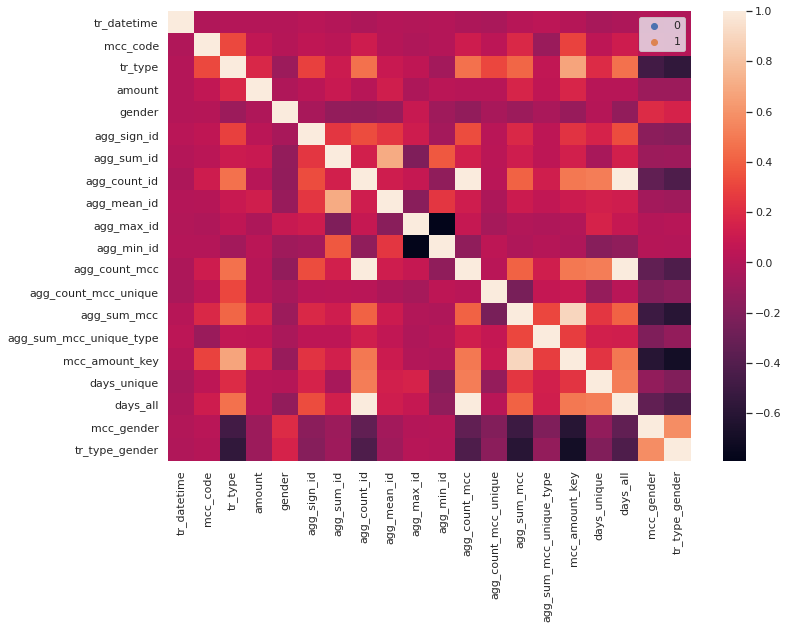

In [37]:
#check correlation
import seaborn as sns; sns.set()
corr = train.corr()
print(corr)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr);

In [ ]:
#check kmeans klustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
pca = PCA(2)
df = pca.fit_transform(x_train)
 
kmeans = KMeans(n_clusters= 2)
label = kmeans.fit_predict(df)
u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [38]:
y_train = train['gender']
x_train = train.drop(columns = ['gender'])
y_test = test['gender']
x_test = test.drop(columns = ['gender'])

scale =  False
if scale:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)


# XGBClassifier

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

print('>>>>>>>>>', 'XGBClassifier')

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)
              
model.fit(x_train, y_train)

>>>>>>>>> XGBClassifier


/home/musaev_rv/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:29:09] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#add_nans
nans = False
if nans:
    y_pred_nan = pd.DataFrame(model.predict(data_nan), index = data_nan.index)
    X_train = pd.concat([x_train, data_nan], axis = 0)
    Y_train = pd.concat([y_train, y_pred_nan], axis = 0)
    print(X_train.shape, x_train.shape)
    model.fit(X_train, Y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_pred)
y_pred = model.predict(x_train)
roc_auc_train = roc_auc_score(y_train, y_pred)

print('mean accuracy score on test: ' + str(accuracy))
print('roc_auc_score on test: '+ str(roc_auc_test))
print('roc_auc_score on train: '+ str(roc_auc_train))

# Grid search

In [ ]:
#define a number of folds and parameter combinations
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 6, 7, 8, 9]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 5
param_comb = 4
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4,
                                    cv=skf.split(x_train,y_train), verbose=3, random_state=1001)

start_time = timer(None) 
random_search.fit(x_train, y_train)
timer(start_time) 

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

# SHAP/ feature importance


In [ ]:
import shap

shap_test = shap.TreeExplainer(model).shap_values(x_train)
shap.summary_plot(shap_test, x_train,
                      max_display=25, auto_size_plot=True)